# 综合实战作业 1

> by [@RainEggplant](https://github.com/RainEggplant/)

在本次作业中，我们将使用 NumPy 和 PyTorch 计算第一讲中生成的字符图像间的相似度并进行排序，输出不同相似度的图像对。你只需要在 `# >>> TODO` 和 `# <<< TODO` 间填写代码。

## 数据读取

首先，让我们定义加载数据集的函数。步骤如下：

- 先使用 `pathlib.Path.glob` 找出所有扩展名为 `.jpg` 的文件。如果你不习惯使用 `pathlib` 库，可以用 `os` 和 `glob` 库替代。
- 再使用 `cv2.imread` 读取图像并用 `cv2.cvtColor` 转换为灰度格式，并用 `pathlib.Path.stem` 提取文件名。
- 通过列表生成式生成所有的数据条目 `data`。

`data` 中每条数据的格式为 `(img_name: str, img: numpy.ndarray)`。

In [3]:
import cv2
from pathlib import Path
def load_dataset(data_root):
    data = [(f.stem, cv2.cvtColor(cv2.imread(str(f)), cv2.COLOR_BGR2GRAY))
    for f in Path(data_root).glob('*.jpg')]
    return data

让我们读取数据集，并使用 `matplotlib` 打印图像看看它长什么样子。

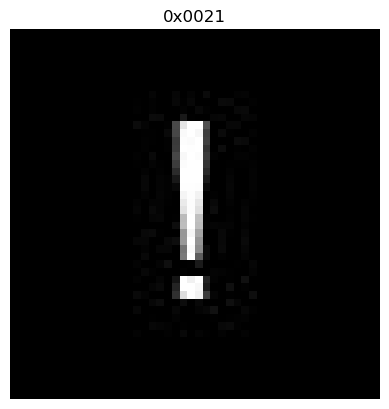

In [4]:
import matplotlib.pyplot as plt

data = load_dataset('./data')

def imshow(img, title=None):
    plt.figure()
    plt.imshow(img, cmap='gray')
    if title is not None: plt.title(title)
    plt.axis('off')

img_name, img = data[0]
imshow(img, img_name)

我们检测重复和相似图像的原理是计算图像向量间的余弦相似度。对于图像 $\mathbf X_1, \mathbf X_2 \in M_{H,W,C} (\mathbb R)$，我们首先将其展平为列向量 $\boldsymbol y_1, \boldsymbol y_2 \in \mathbb R^{HWC}$，然后计算两个向量的余弦相似度：
$$
S_{C}(\boldsymbol y_1, \boldsymbol y_2):=\frac{\boldsymbol y_1 \cdot \boldsymbol y_2}{\|\boldsymbol y_1 \|\|\boldsymbol y_2 \|}
$$
相似度越接近 1，说明两幅图像越相似。在计算相似度时，建议先将像素取值转换为浮点数并归一化，防止溢出和数据类型带来的问题。

下面我们将按照这个思路，分别采用 NumPy 和 PyTorch 实现计算图像相似度的算法（PyTorch 部分内容可在第三讲培训之后完成），并对比不同实现的速度。特别地，对于 NumPy， 我们先尝试简单的多重 for 循环的实现，再尝试采用矩阵计算的实现。

## 使用 NumPy 和两重循环

下面请你用两重循环，计算图片间的两两相似度，并将相似度取值和对应的图像对序号保存到列表中。注意不要包括“图像自己和自己组成的图像对”以及“可交换顺序的图像组成的图像对”。

In [5]:
import numpy as np

similarity_list = []
pair_list = []
# >>> TODO
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        y_a = np.ravel(data[i][1].astype(float) / 255)  # 使用 `np.ravel` 将图像展平为向量
        y_b = np.ravel(data[j][1].astype(float) / 255)
        similarity = np.dot(y_a, y_b) / (np.linalg.norm(y_a) * np.linalg.norm(y_b))
        similarity_list.append(similarity)
        pair_list.append((i, j))
# <<< TODO

挺慢是吧！下一节直接用矩阵计算时，你就能非常直观地感受运算速度的差别。

下面请你按照从大到小的顺序对相似度进行排序，保存排序后的索引列表。

In [6]:
# >>> TODO
indexes = np.flip(np.argsort(similarity_list))
print(indexes)

# <<< TODO

[   382  88477  89657 ... 611401 611402 126575]


## 使用 NumPy 和矩阵运算

其实，我们可以使用矩阵运算一次性计算所有图像的两两相似度，这可以大大加快计算速度。计算公式如下：
$$
\mathbf Y = \begin{pmatrix}
\boldsymbol y_1^\intercal \\
\boldsymbol y_2^\intercal \\
\vdots \\
\boldsymbol y_n^\intercal
\end{pmatrix}
\\
\mathbf W = \mathbf Y \mathbf Y^\intercal \\
\mathbf N = (\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|)^\intercal(\|\boldsymbol y_1 \|, \|\boldsymbol y_2 \|, \dots, \|\boldsymbol y_n \|) \\
\mathbf S = \mathbf W \oslash \mathbf N
$$

其中 $\oslash$ 表示逐元素除法。则图像 $\mathbf X_i, \mathbf X_j$ 的相似度为 $\mathbf S$ 的元素 $s_{i,j}$。

下面请你根据以上计算公式，完成矩阵版本的 NumPy 计算代码。

In [7]:
# >>> TODO
Y = np.stack([np.ravel(x[1]) for x in data])
# 将数据格式从 uint8 转为 float 以便后续计算。
Y = Y.astype(float) / 255

W = Y @ Y.T
N = np.linalg.norm(Y, axis=1)  # 求每行向量的模长
N = N[..., None] * N[None]  # nx1 数组与 1xn 数组相乘
S = W / N  # 逐元素除法
# <<< TODO

因为每幅图像与自身的相似度一定为 1，且矩阵 $\mathbf S$ 为对称矩阵，所以实际有效的部分为 $\mathbf S$ 的减去主对角线的上三角矩阵。然后，我们对相似度按从大到小的方向进行排序，即可找出相同或相似的图像对。请你完成如下排序代码，要求最终得到元素为 `(行号，列号)` 的索引列表。

In [8]:
S = np.triu(S, k=1)  # S 的减去主对角线的上三角矩阵
# >>> TODO
# 对 S 的元素按照从大到小进行排序，得到元素的索引。
indexes = np.flip(S.argsort(axis=None))
# 使用 `np.unravel_index` 根据数组的尺寸将索引转换为 `(行号，列号)` 形式。
indexes = [np.unravel_index(i, S.shape) for i in indexes]
# <<< TODO

下面我们借助 matplotlib 来看一看不同相似度的图像（还没学过 matplotlib 没关系，相关的代码已为你写好）。请你定义一个 `plot_results(data, S, indexes)` 函数，接受图像数据 `data`、相似度矩阵 `S` 和排序后的索引 `indexes` 为输入，以 2x2 subplot 的方式，画出相似度排名最高、第 0.1%、第 1% 和第 10% 的图像对。要求在每个 subplot 中，先将图像对的两幅图像沿宽度拼接，然后再进行绘制，并使用相似度作为图像的标题。

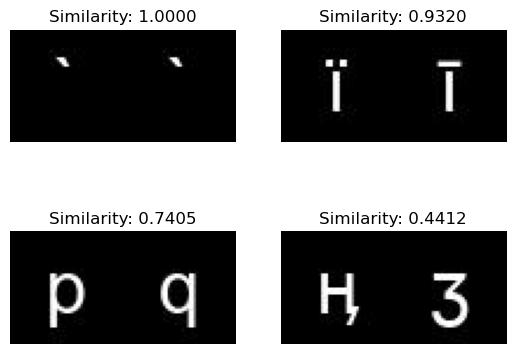

In [9]:
def plot_results(data, S, indexes):
    plot_indexes = [0, int((len(indexes) - 1) * 1e-3),
                    int((len(indexes) - 1) * 1e-2), int((len(indexes) - 1) * 1e-1)]
    fig, axs = plt.subplots(2, 2)
    for r in range(2):
        for c in range(2):
            # >>> TODO
            i = r * 2 + c
            img1_id, img2_id = indexes[plot_indexes[i]]
            img1_name, img1 = data[img1_id]
            img2_name, img2 = data[img2_id]
            img = np.hstack([img1, img2])
            similarity = S[img1_id, img2_id]
            # <<< TODO
            axs[r, c].imshow(img, cmap='gray')
            axs[r, c].set_title(f'Similarity: {similarity:.4f}')
            axs[r, c].axis('off')

plot_results(data, S, indexes)

## 使用 PyTorch 和矩阵运算

请仿照上一节，使用 PyTorch + 矩阵运算解决该问题。首先请你计算图像的相似度矩阵 `S`：

In [10]:
import torch

# 根据 CUDA 是否可用确定使用的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# >>> TODO
# 请注意将 Tensor 存放在 `device` 定义的设备上。
# 首先使用 `torch.ravel` 将图像展平为向量，然后使用 `torch.stack` 将所有向量堆叠成二维张量。
Y = torch.stack([torch.ravel(torch.tensor(x[1])) for x in data])
# 将数据格式从 uint8 转为 float 以便后续计算。
Y = Y.to(device, dtype=float) / 255

W = Y @ Y.T
N = torch.linalg.norm(Y, dim=1)  # 求每行向量的模长
N = N[..., None] * N[None]  # nx1 张量与 1xn 张量相乘
S = W / N  # 逐元素除法
# <<< TODO

请你仿照上一节，对相似度矩阵 S 的元素进行排序，并得到元素为 `(行号，列号)` 的索引列表：

In [11]:
S = torch.triu(S, diagonal=1)  # S 的减去主对角线的上三角矩阵

# >>> TODO
# 不同于 NumPy，PyTorch 中对张量的所有元素排序需要先将其展平为向量，不过 PyTorch 可以指定排序的方向。
indexes = S.ravel().argsort(descending=True).tolist()
# PyTorch 中没有 `np.unravel_index` 这样的函数，不过自己实现也不难。
indexes = [(i // S.shape[1], i % S.shape[1]) for i in indexes]
# <<< TODO

让我们看看 PyTorch 的结果吧！

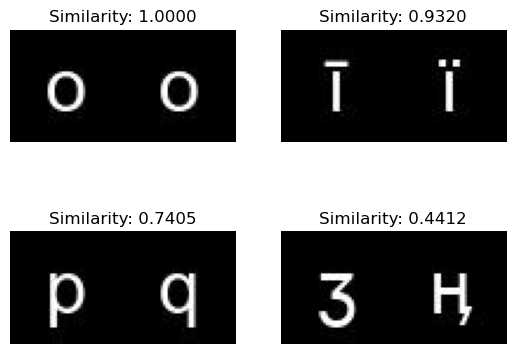

In [12]:
plot_results(data, S, indexes)

## NumPy 和 PyTorch 速度测试

最后，让我们对比一下三种方式的执行速度。这里我们会创建一个可以统计函数运行时间的 [装饰器](https://www.liaoxuefeng.com/wiki/1016959663602400/1017451662295584)，感兴趣的同学可以点击链接了解其原理。

In [13]:
from functools import wraps
from time import perf_counter

def timer(func):
    # This function shows the execution time of the function object passed
    @wraps(func)
    def wrap_func(*args, **kwargs):
        args_str = ', '.join([f'{v!r}' for v in args])
        kwargs_str = ', '.join([f'{k}={v!r}' for k, v in kwargs.items()])
        comma_str = ', ' if (args_str != '' and kwargs_str != '') else ''
        t_start = perf_counter()
        result = func(*args, **kwargs)
        t_end = perf_counter()
        print(f'Function {func.__name__}({args_str}{comma_str}{kwargs_str}) executed in {(t_end - t_start):.4f}s')
        return result

    return wrap_func

接下来我们分别定义三种方式的测试函数（你需要把前面的代码复制粘贴过来）。

In [14]:
@timer
def test_numpy_for_loop():
    @timer
    def load_and_calc():
        similarity_list = []
        pair_list = []
        # >>> TODO
        for i in range(len(data)):
            for j in range(i + 1, len(data)):
                y_a = np.ravel(data[i][1].astype(float) / 255)  # 使用 `np.ravel` 将图像展平为向量
                y_b = np.ravel(data[j][1].astype(float) / 255)
                similarity = np.dot(y_a, y_b) / (np.linalg.norm(y_a) * np.linalg.norm(y_b))
                similarity_list.append(similarity)
                pair_list.append((i, j))
        # <<< TODO
        return similarity_list, pair_list
    similarity_list, pair_list = load_and_calc()

    @timer
    def sort():
        # >>> TODO
        indexes = np.flip(np.argsort(similarity_list))
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_numpy():
    @timer
    def load():
        # >>> TODO
        Y = np.stack([np.ravel(x[1]) for x in data])
        Y = Y.astype(float) / 255
        # <<< TODO
        return Y
    Y = load()

    @timer
    def calc():
        # >>> TODO
        W = Y @ Y.T
        N = np.linalg.norm(Y, axis=1)
        N = N[..., None] * N[None]
        S = W / N
        # <<< TODO
        S = np.triu(S, k=1)
        return S
    S = calc()

    @timer
    def sort():
        # >>> TODO
        indexes = np.flip(S.argsort(axis=None))
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes


@timer
def test_torch(device=device):
    @timer
    def load():
        # >>> TODO
        Y = torch.stack([torch.ravel(torch.tensor(x[1])) for x in data])
        Y = Y.to(device, dtype=float) / 255
        # <<< TODO
        return Y
    Y = load()

    @timer
    def calc():
        # >>> TODO
        W = Y @ Y.T
        N = torch.linalg.norm(Y, dim=1)
        N = N[..., None] * N[None]
        S = W / N
        # <<< TODO
        S = torch.triu(S, diagonal=1)
        return S
    S = calc()

    @timer
    def sort():
        # >>> TODO
        indexes = S.ravel().argsort(descending=True)
        # <<< TODO
        return indexes
    indexes = sort()
    return indexes

下面进行测试。

In [15]:
test_numpy_for_loop()
print('-' * 50)
test_numpy()
print('-' * 50)
test_torch()
if device == 'cuda':
    print('-' * 50)
    test_torch('cpu')

Function load_and_calc() executed in 18.5146s
Function sort() executed in 0.0865s
Function test_numpy_for_loop() executed in 18.6254s
--------------------------------------------------
Function load() executed in 0.0153s
Function calc() executed in 0.0463s
Function sort() executed in 0.0734s
Function test_numpy() executed in 0.1379s
--------------------------------------------------
Function load() executed in 0.0125s
Function calc() executed in 0.0407s
Function sort() executed in 0.0883s
Function test_torch() executed in 0.1447s


你有什么发现吗？请写在下面。